# Задание. Решение конкурса на kaggle.com

Это задание посвящено полноценному решению задачи машинного обучения.

Данные в задании разделены на две части.
* `train.csv`. На этом наборе данных создаём и обучаем модель. 
* `test.csv`. В каждой строчке файла `test.csv` указаны признаки тестовых объектов. Предсказания для этого набора записываем в файл submission.csv и сдаём.

### Контест на Kaggle
[Контест на Kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/). 


Данные: [train.csv](https://drive.google.com/file/d/1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K/view?usp=share_link),
[test.csv](https://drive.google.com/file/d/1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r/view?usp=share_link), [submission.csv](https://drive.google.com/file/d/199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y/view?usp=share_link).

# Метрика

В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она работает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Простой пример расчёта:

In [1]:
from sklearn.metrics import roc_auc_score, roc_curve

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math 
import seaborn as sns

## Загрузка данных 

In [3]:
#!pip install gdown

In [4]:
# !gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
# !gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
# !gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

In [5]:
data = pd.read_csv('./train.csv')

In [6]:
data

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


In [7]:
# смотрим на случайные строчки
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
489,17,102.55,1742.5,Male,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,0
534,72,83.30,6042.7,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),0
570,2,20.35,35.1,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),0
291,22,25.25,555.4,Female,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2427,69,19.80,1436.95,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0


In [8]:
data.describe()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,0.159409,0.262022
std,24.550326,30.176464,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.462500,0.000000,0.000000
50%,29.000000,70.400000,0.000000,0.000000
75%,55.000000,90.050000,0.000000,1.000000
max,72.000000,118.750000,1.000000,1.000000


In [9]:
# смотрим на датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [10]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Отлично, у нас нет nan'ов!
Однако есть колонка TotalSpent с числовыми данными, которые воспринимаются как object. Попробуем разобраться

In [11]:
# поиск проблемы в TotalSpent
data['TotalSpent'].value_counts()

TotalSpent
           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: count, Length: 4978, dtype: int64

In [12]:
# тест гипотез
data[data['TotalSpent'] > '30']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
5,25,19.80,475.2,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
7,1,45.70,45.7,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273,60,104.35,6339.45,Male,1,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Electronic check,0
5275,21,19.95,416.4,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,0
5276,72,98.20,7015.9,Female,0,Yes,No,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0


In [13]:
# для аккуратности
data_2 = data.copy()

In [14]:
# сортировка
data_2.sort_values(by = 'TotalSpent').head(15)
data_2 = data_2.sort_values(by = 'TotalSpent')

In [15]:
data_2_part = data_2[:10]
data_2_part

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
3343,5,24.30,100.2,Male,0,No,No,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,0


Что стало понятно: TotalSpent не заполняется в случае, если ClientPeriod < 1. 
Видимо, эта история о том, что клиент пока что пользуется услугами провайдера меньше месяца, 
а значит, его TotalSpent равен количеству уже произведённых затрат в течение первого месяца 
(MonthlySpending)

In [16]:
# !! transformation
data_2['TotalSpent'][data_2['TotalSpent']==' '] = data_2['MonthlySpending']
data_2

/var/folders/_5/8sz306zn1332jvkj4z4k5yl80000gn/T/ipykernel_83485/552118569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['TotalSpent'][data_2['TotalSpent']==' '] = data_2['MonthlySpending']


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4598,0,56.05,56.05,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0
2543,0,19.70,19.7,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
4551,0,52.55,52.55,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
1707,0,73.35,73.35,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
3078,0,80.85,80.85,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3557,23,44.95,996.85,Female,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0
141,51,19.85,996.95,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0
4317,11,95.15,997.65,Female,1,No,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),1
3376,55,19.15,998.1,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),0


In [17]:
# переводим в цифры 
data_2['TotalSpent'] = data_2['TotalSpent'].astype(float)
data_2.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2287.564824,0.159409,0.262022
std,24.550326,30.176464,2268.970866,0.366092,0.439776
min,0.000000,18.250000,18.800000,0.000000,0.000000
25%,9.000000,35.462500,395.725000,0.000000,0.000000
50%,29.000000,70.400000,1405.650000,0.000000,0.000000
75%,55.000000,90.050000,3795.212500,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


In [18]:
# убедимся, что больше нигде нет null
data_2[data_2.isnull().any(axis=1)]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn


In [19]:
# убедимся, что больше нигде нет nan'ов
data_false = data.isna()
data_false.value_counts()

ClientPeriod  MonthlySpending  TotalSpent  Sex    IsSeniorCitizen  HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  HasInternetService  HasOnlineSecurityService  HasOnlineBackup  HasDeviceProtection  HasTechSupportAccess  HasOnlineTV  HasMovieSubscription  HasContractPhone  IsBillingPaperless  PaymentMethod  Churn
False         False            False       False  False            False       False     False            False                    False               False                     False            False                False                 False        False                 False             False               False          False    5282
Name: count, dtype: int64

In [20]:
data_false.mean()

ClientPeriod                0.0
MonthlySpending             0.0
TotalSpent                  0.0
Sex                         0.0
IsSeniorCitizen             0.0
HasPartner                  0.0
HasChild                    0.0
HasPhoneService             0.0
HasMultiplePhoneNumbers     0.0
HasInternetService          0.0
HasOnlineSecurityService    0.0
HasOnlineBackup             0.0
HasDeviceProtection         0.0
HasTechSupportAccess        0.0
HasOnlineTV                 0.0
HasMovieSubscription        0.0
HasContractPhone            0.0
IsBillingPaperless          0.0
PaymentMethod               0.0
Churn                       0.0
dtype: float64

Теперь всё готово

In [21]:
# Для удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = ['Churn']

In [22]:
cols = feature_cols + target_col
data_2 = data_2[cols]
# data_2.head(20)

## Анализ данных

array([[<Axes: title={'center': 'ClientPeriod'}>,
        <Axes: title={'center': 'MonthlySpending'}>],
       [<Axes: title={'center': 'TotalSpent'}>,
        <Axes: title={'center': 'IsSeniorCitizen'}>],
       [<Axes: title={'center': 'Churn'}>, <Axes: >]], dtype=object)

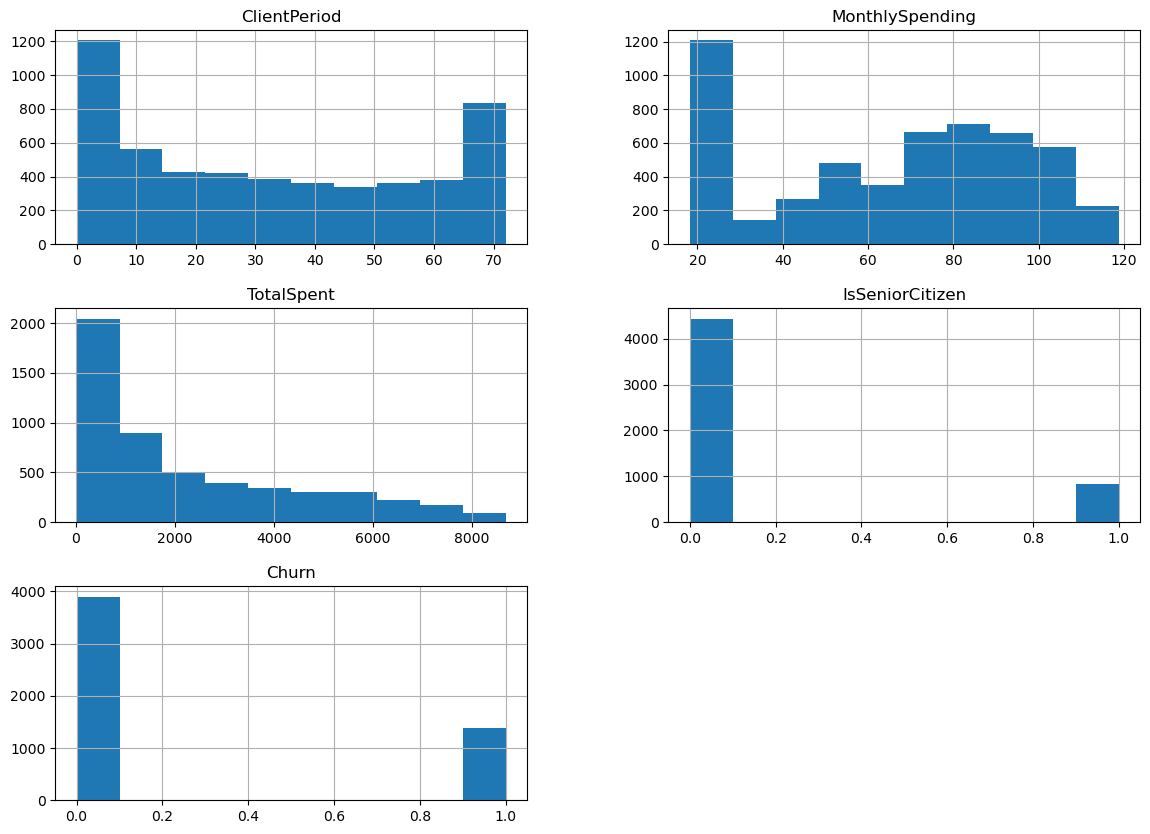

In [23]:
# Посмотрим на распредление численных признаков
data_2.hist(column=num_cols+cat_cols+target_col, figsize=(14, 10))

In [24]:
# посмотрим на соотношение в количестве значений целевой переменной обоих классов (0 и 1)
num_of_ones = len(data_2['Churn'][data_2['Churn']== 1])
num_of_zeros = len(data_2['Churn'][data_2['Churn']== 0])
fraction = float(num_of_zeros) / float(num_of_ones)
fraction

2.816473988439306

Глядя на получившееся соотношение, я бы не сказала, что классы являются несбалансированными, т.к. объектов класса 0 всего в 2.8 раза больше, т.е. даже не на порядок

In [25]:
# Посмотрим на распределение категориальных признаков

for col in cat_cols:
    print(f"{col} DISTRIBUTION")
    print(data_2[col].value_counts())
    print() 

Sex DISTRIBUTION
Sex
Male      2655
Female    2627
Name: count, dtype: int64

IsSeniorCitizen DISTRIBUTION
IsSeniorCitizen
0    4440
1     842
Name: count, dtype: int64

HasPartner DISTRIBUTION
HasPartner
No     2705
Yes    2577
Name: count, dtype: int64

HasChild DISTRIBUTION
HasChild
No     3676
Yes    1606
Name: count, dtype: int64

HasPhoneService DISTRIBUTION
HasPhoneService
Yes    4761
No      521
Name: count, dtype: int64

HasMultiplePhoneNumbers DISTRIBUTION
HasMultiplePhoneNumbers
No                  2511
Yes                 2250
No phone service     521
Name: count, dtype: int64

HasInternetService DISTRIBUTION
HasInternetService
Fiber optic    2341
DSL            1800
No             1141
Name: count, dtype: int64

HasOnlineSecurityService DISTRIBUTION
HasOnlineSecurityService
No                     2612
Yes                    1529
No internet service    1141
Name: count, dtype: int64

HasOnlineBackup DISTRIBUTION
HasOnlineBackup
No                     2332
Yes               

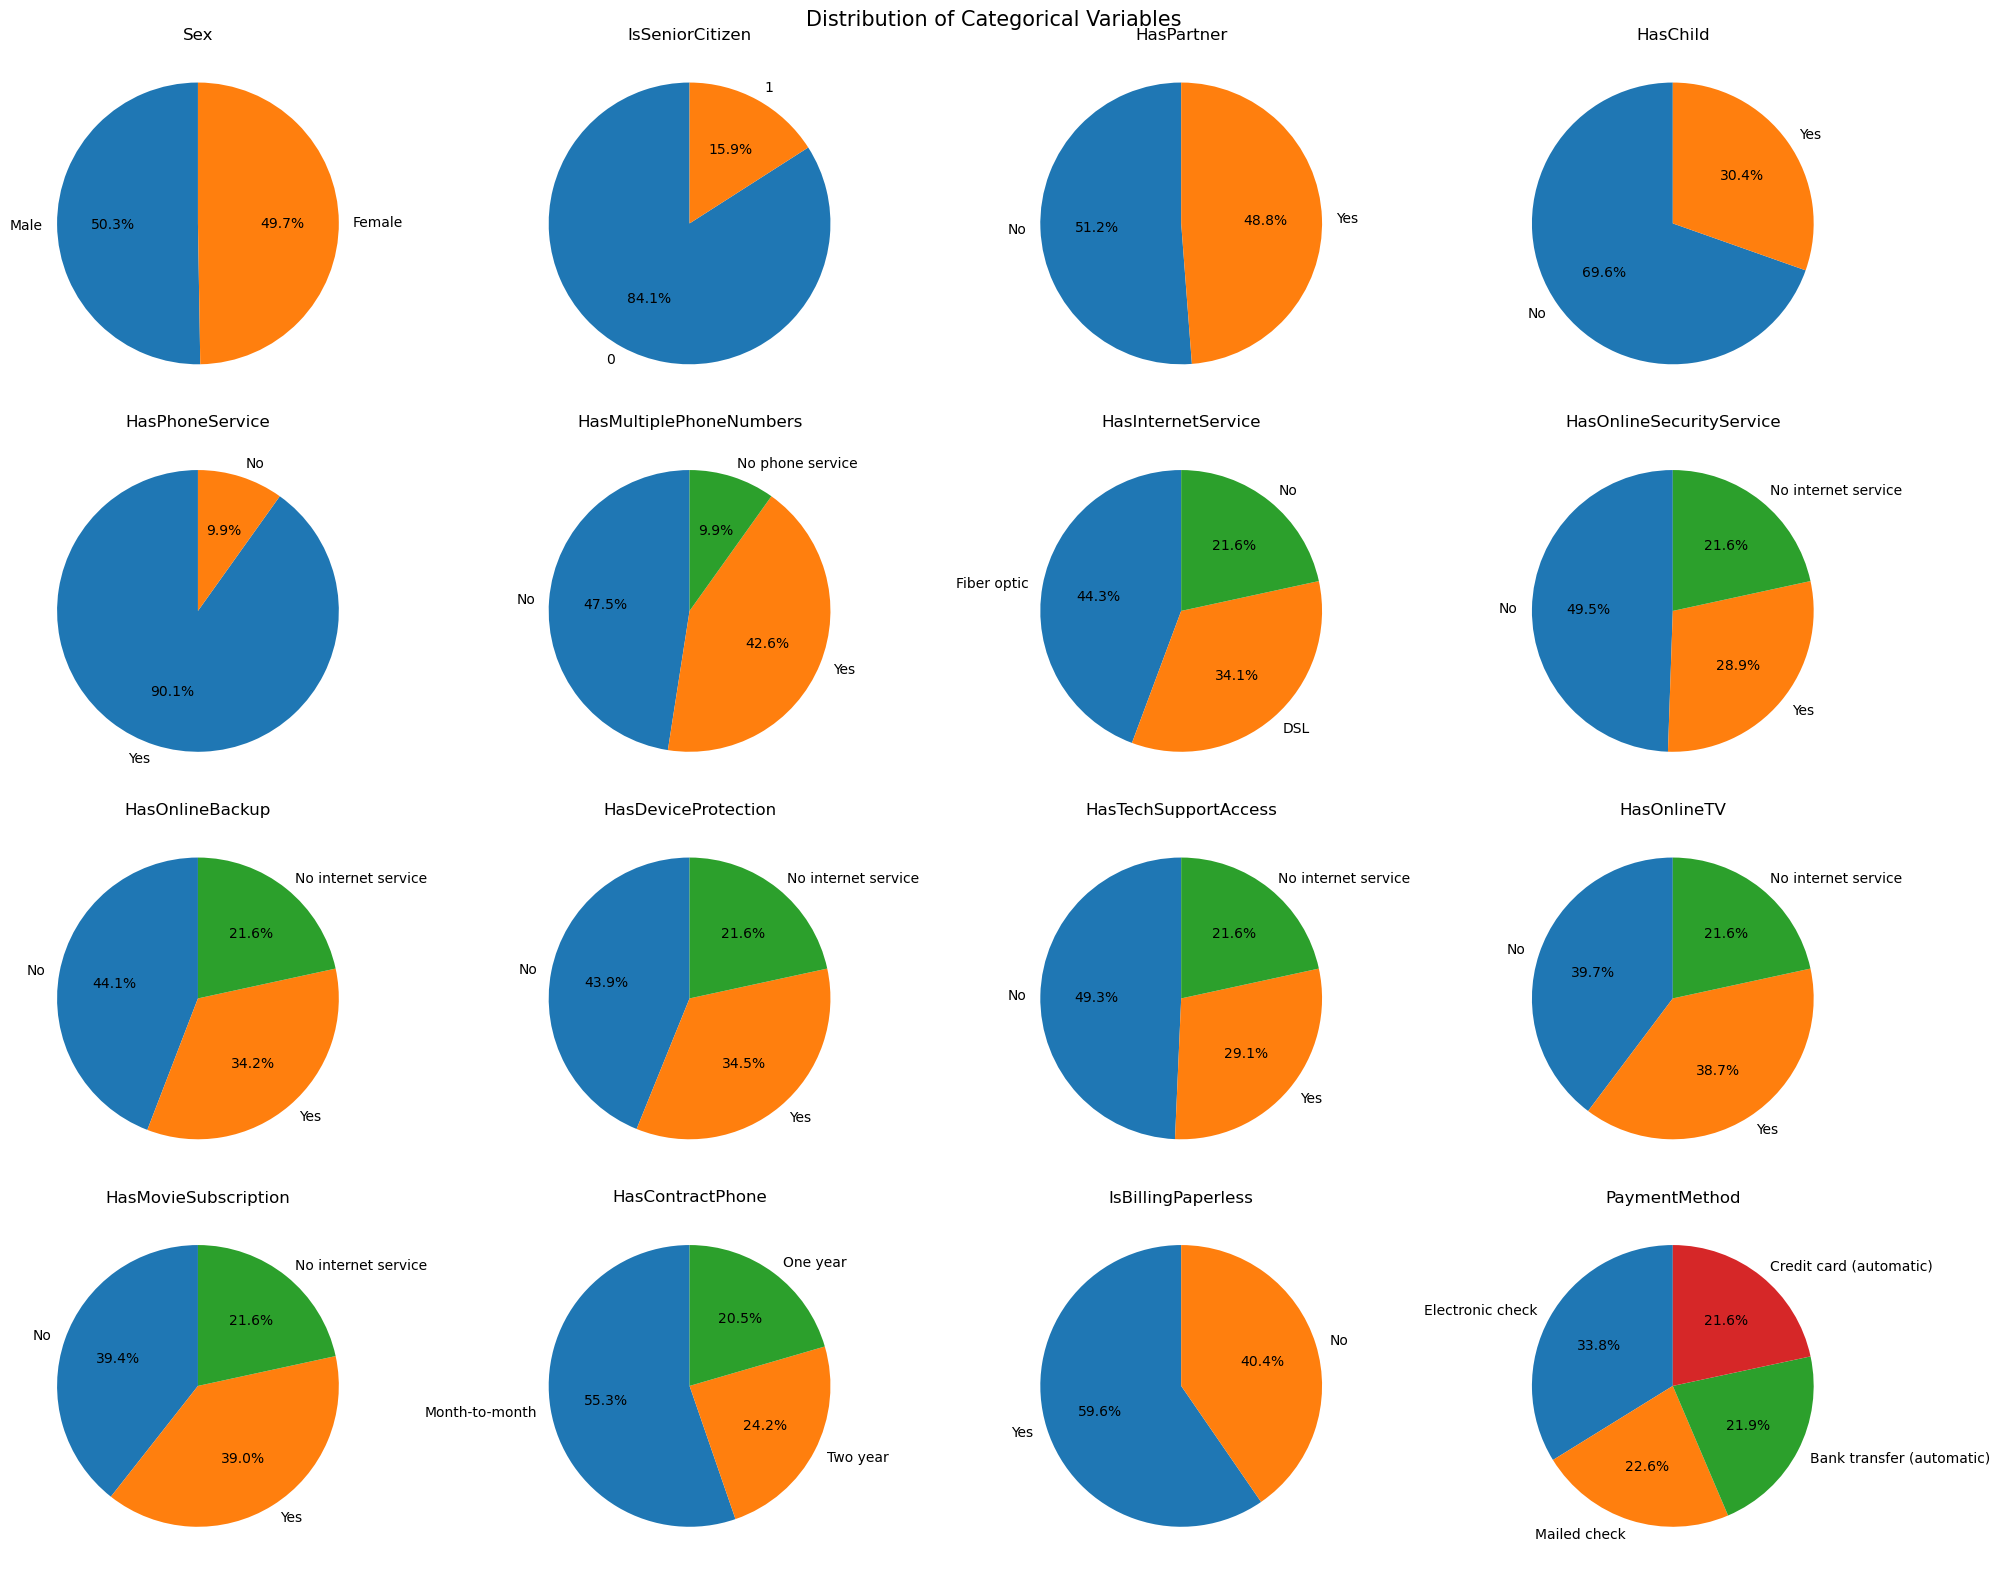

In [26]:
n_cols = 4  
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
fig.suptitle('Distribution of Categorical Variables', fontsize=15)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Create a pie plot for each categorical column
for i, col in enumerate(cat_cols):
    # Get value counts and sort them in descending order
    value_counts = data_2[col].value_counts().sort_values(ascending=False)
    
    # Plot the pie chart
    axes[i].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(col)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Что можно сказать: 
1) в каждой из фичей максимальное количество возможных значений = 4. Это значит, что применение OHE не приведёт к капитальному разрастанию таблицы -> будем применять
2) существенного дисбаланса нигде не наблюдается, разве что в фиче HasPhoneService

In [27]:
numeric_data = data_2[num_cols]

categorial_data = data_2[cat_cols]
type(numeric_data.head(30)), len(numeric_data)

(pandas.core.frame.DataFrame, 5282)

In [28]:
numeric_data.corr().style.background_gradient(cmap='coolwarm') 

,ClientPeriod,MonthlySpending,TotalSpent
ClientPeriod,1.000000,0.249414,0.826641
MonthlySpending,0.249414,1.000000,0.652027
TotalSpent,0.826641,0.652027,1.000000


Ожидаемо, есть сильная корреляция между ClientPeriod и TotalSpent, а также между MonthlySpending и TotalSpent. Мне кажется, что от чего-то точно стоит избавиться (линейные модели не любят параметры с высокой взаимной корреляцией), и, с целью сохранить больше данных, думаю удалить TotalSpent

## Применение линейных моделей

In [30]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer

In [31]:
# нормировка числовых признаков
pca = StandardScaler()

num_cols_scaled = pca.fit_transform(numeric_data)

In [32]:
num_features_sc = pd.DataFrame(num_cols_scaled, columns=num_cols)

In [33]:
# кодировка категориальных признаков с помощью one-hot encoding
dummy_cat_features = pd.get_dummies(categorial_data)

In [34]:
# объединяем в общим датафрейм
X = pd.concat([num_features_sc, dummy_cat_features], axis=1)
X

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.319741,-0.294123,-0.983585,0,False,True,False,True,False,True,...,False,False,True,False,True,False,False,False,False,True
1,-1.319741,-1.498818,-0.999607,0,False,True,False,True,True,False,...,False,False,False,True,True,False,False,True,False,False
2,-1.319741,-0.410118,-0.985128,0,False,True,True,False,True,False,...,False,True,False,False,False,True,False,False,True,False
3,-1.319741,0.279226,-0.975960,1,True,False,False,True,True,False,...,False,True,False,False,True,False,False,False,False,True
4,-1.319741,0.527787,-0.972654,0,True,False,False,True,False,True,...,True,False,False,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,-0.382801,-0.661994,-0.568909,0,False,True,True,False,True,False,...,False,True,False,False,True,False,False,False,True,False
5278,0.757821,-1.493847,-0.568865,0,False,True,False,True,True,False,...,False,False,True,False,False,True,True,False,False,False
5279,-0.871640,1.001711,-0.568556,0,False,True,True,False,True,False,...,False,True,False,False,True,False,False,False,False,True
5280,0.920767,-1.517046,-0.568358,0,True,False,True,False,True,False,...,False,True,False,False,False,True,False,True,False,False


In [35]:
# выделяем из оригинальной таблицы все столбцы, кроме целевого
X_origin = data_2.iloc[:, :-1]

In [36]:
y = data_2['Churn']
y

4598    0
2543    0
4551    0
1707    0
3078    0
       ..
3557    0
141     0
4317    1
3376    0
1157    0
Name: Churn, Length: 5282, dtype: int64

In [37]:
X.shape, X_origin.shape
# видим, как выросло количество столбцов в датафрейме ввиду применения OHE к категориальным признакам

((5282, 45), (5282, 19))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    shuffle=True)

In [39]:
def print_metrics(y_preds, y):
    print(f'R^2: {r2_score(y_preds, y)}')
    print(f'MSE: {mean_squared_error(y_preds, y)}')

In [40]:
# Используем обычную линейную регрессию, минимизирующую сумму квадратов ошибки
linreg = LinearRegression()
linreg.fit(X_train, y_train)

print_metrics(linreg.predict(X_test), y_test)

R^2: -2.6692759990518846
MSE: 0.15893982713134536


In [41]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print_metrics(knn.predict(X_test), y_test)

R^2: -1.03344582071046
MSE: 0.2847682119205298


In [42]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train);

print_metrics(tree.predict(X_test), y_test)

R^2: -0.5446200556154588
MSE: 0.2923368022705771


In [43]:
logreg = LogisticRegression(C=1.1)
logreg.fit(X_train, y_train);

print_metrics(logreg.predict(X_test), y_test)

y_train_predicted = logreg.predict_proba(X_train)[:, 1]
y_test_predicted = logreg.predict_proba(X_test)[:, 1]

R^2: -0.49409898398824725
MSE: 0.21665089877010407


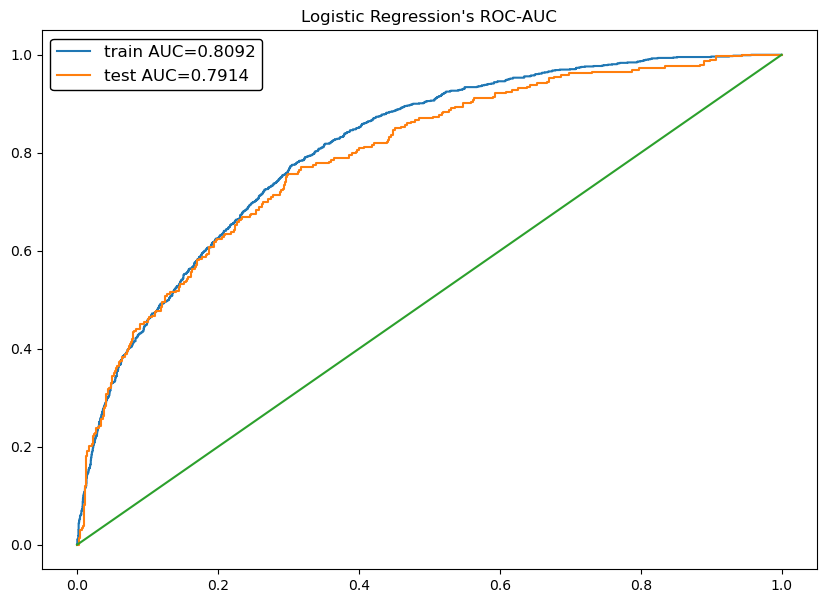

In [44]:
train_auc = roc_auc_score(y_train, y_train_predicted);
test_auc = roc_auc_score(y_test, y_test_predicted);

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.title('Logistic Regression\'s ROC-AUC')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Решила попробовать руками перебрать гиперпараметр C (в ячейке выше уже найденное значение 

In [45]:
# заново создадим модель
model = LogisticRegression()

# опишем сетку, по которой будем искать
param_grid = {
    'C': np.arange(0.1, 5), # также можно указать обычный массив, [1, 2, 3, 4]
}

# создадим объект GridSearchCV
gridsearch = GridSearchCV(model, param_grid, refit=True, scoring=make_scorer(roc_auc_score))

# запустим поиск
gridsearch.fit(X_train, y_train)

# выведем наилучшие параметры
print(gridsearch.best_params_)

best_model = gridsearch.best_estimator_

print(f'ROC-AUC train = {roc_auc_score(y_train, best_model.predict(X_train))}')
print(f'ROC-AUC test = {roc_auc_score(y_test, best_model.predict(X_test))}');

{'C': 1.1}
ROC-AUC train = 0.6692945764411146
ROC-AUC test = 0.6733891142361917


R^2: -0.49409898398824725
MSE: 0.21665089877010407
ROC-AUC: 0.6733891142361917


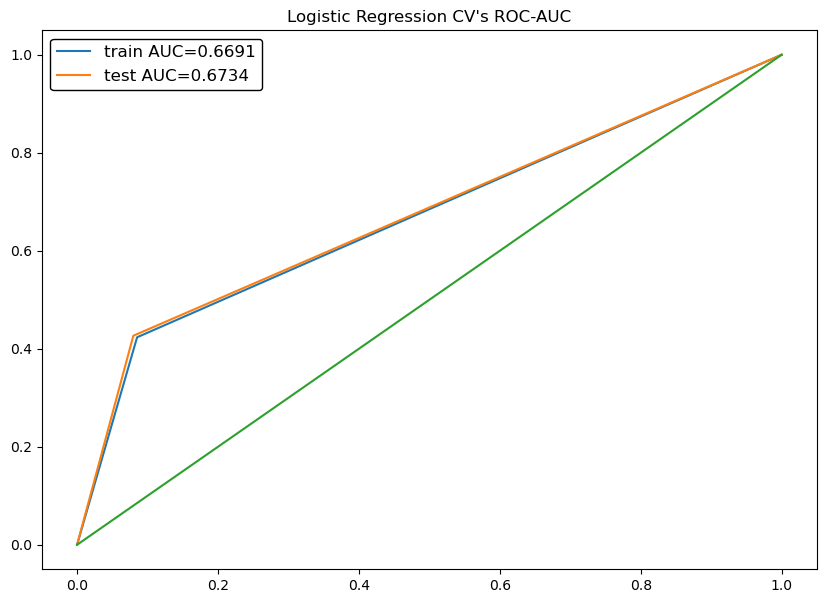

In [46]:
logregcv = LogisticRegressionCV(scoring='roc_auc', refit=True)

logregcv.fit(X_train, y_train)
print_metrics(logregcv.predict(X_test), y_test)
print(f'ROC-AUC: {roc_auc_score(y_test, logreg.predict(X_test))}')


train_auc = roc_auc_score(y_train, logregcv.predict(X_train))
test_auc = roc_auc_score(y_test, logreg.predict(X_test))

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, logregcv.predict(X_train))[:2], label='train AUC={:.4f}'.format(train_auc)) 
plt.plot(*roc_curve(y_test, logreg.predict(X_test))[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.title('Logistic Regression CV\'s ROC-AUC')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [47]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid} 

    CV_model = GridSearchCV(estimator=model,
                            param_grid=parameters,
                            cv=5,
                            # scoring='roc_auc', 
                            scoring='f1',
                            n_jobs=-1,
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']

    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error,
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()

    return means, error

Fitting 5 folds for each of 50 candidates, totalling 250 fits


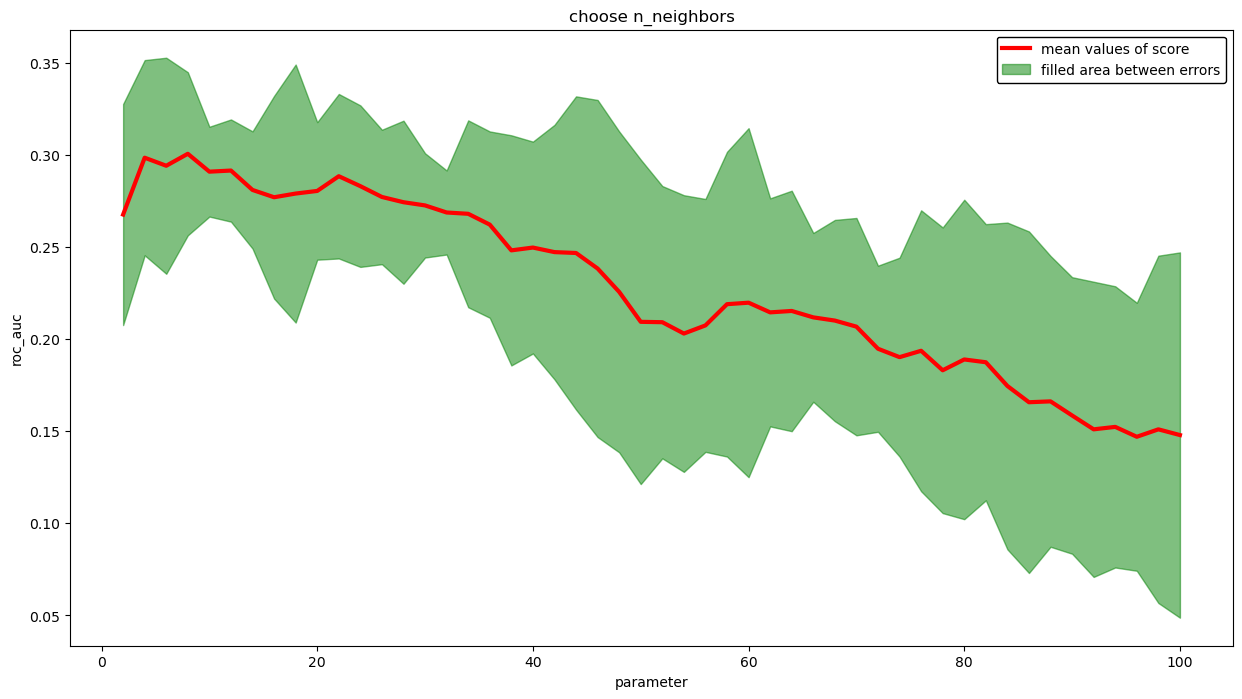

In [48]:
search_and_draw(X_train, y_train, KNeighborsClassifier(), 'n_neighbors',
                np.array(np.linspace(2, 100, 50), dtype='int'), 'linear');

Печаль на knn

Fitting 5 folds for each of 50 candidates, totalling 250 fits


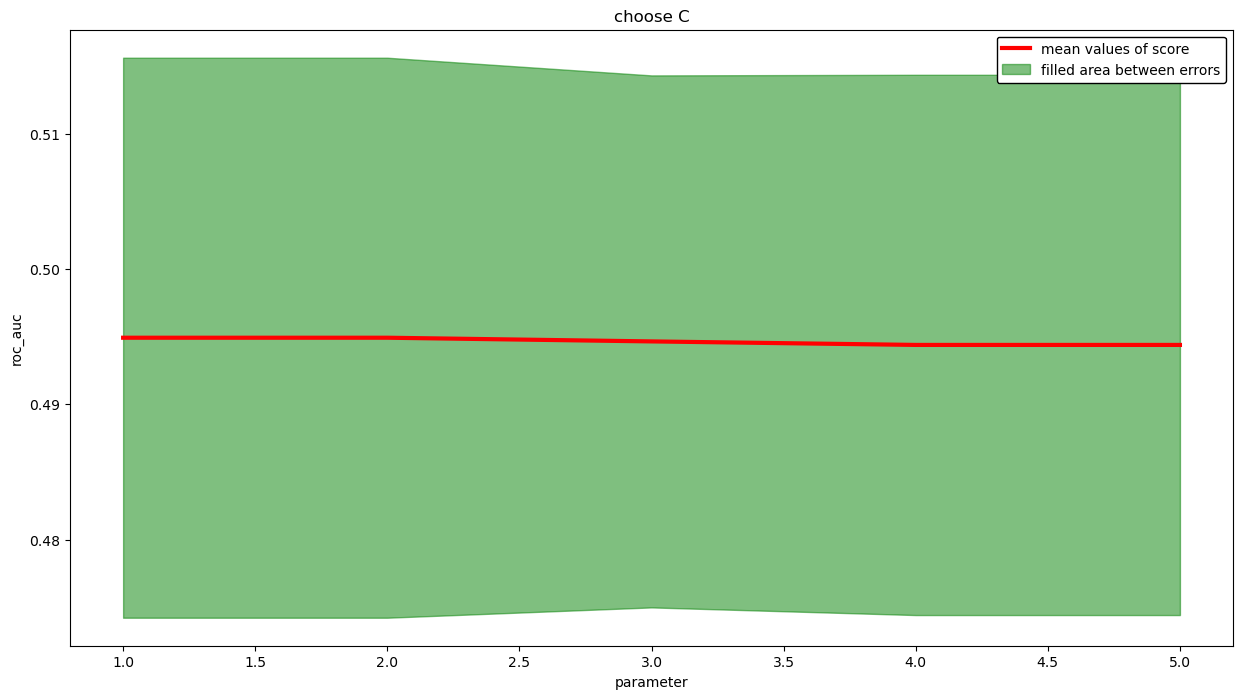

In [49]:
search_and_draw(X_train, y_train, LogisticRegression(), 'C',
                np.array(np.linspace(1.0, 5, 50), dtype='int'), 'linear');

Остальные делаются аналогично. Бустинг всё равно даёт результаты лучше... 

## Применение градиентного бустинга

In [50]:
# начнём с xgboost
# !pip install xgboost

In [51]:
import xgboost

In [52]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

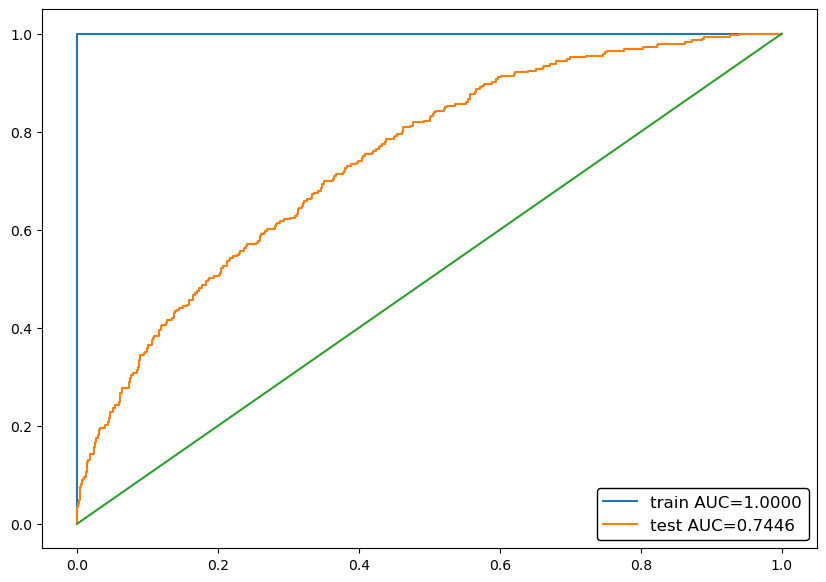

In [53]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [54]:
# теперь catboost
# !pip3 install catboost

In [55]:
from catboost import CatBoostClassifier, Pool

In [56]:
X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values,
                                                       train_size=0.8,
                                                       random_state=42,
                                                       shuffle=True)

In [57]:
# снова для аккуратности
X_origin_cat = X_origin.copy()

In [59]:
# заменим категориальные фичи на индексы
for cat in cat_cols:
    X_origin_cat[cat] = X_origin_cat[cat].astype('category')

In [60]:
X_origin_cat

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
4598,0,56.05,56.05,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic)
2543,0,19.70,19.70,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check
4551,0,52.55,52.55,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic)
1707,0,73.35,73.35,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check
3078,0,80.85,80.85,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3557,23,44.95,996.85,Female,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check
141,51,19.85,996.95,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic)
4317,11,95.15,997.65,Female,1,No,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic)
3376,55,19.15,998.10,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic)


In [61]:
# убедимся, что всё в порядке
X_origin_cat.dtypes

ClientPeriod                   int64
MonthlySpending              float64
TotalSpent                   float64
Sex                         category
IsSeniorCitizen             category
HasPartner                  category
HasChild                    category
HasPhoneService             category
HasMultiplePhoneNumbers     category
HasInternetService          category
HasOnlineSecurityService    category
HasOnlineBackup             category
HasDeviceProtection         category
HasTechSupportAccess        category
HasOnlineTV                 category
HasMovieSubscription        category
HasContractPhone            category
IsBillingPaperless          category
PaymentMethod               category
dtype: object

In [62]:
X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_origin_cat, y,
                                                            test_size=0.2, 
                                                            random_state=42, 
                                                            shuffle=True
                                                            )

print("Training set shape:", X_train_cat.shape)
print("Testing set shape:", X_test_cat.shape)

Training set shape: (4225, 19)
Testing set shape: (1057, 19)


In [63]:
cat_cols = X_origin_cat.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)

Categorical columns: ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']


In [64]:
# Create Pool objects for CatBoost
train_pool = Pool(X_train_cat, y_train, cat_features=cat_cols)
test_pool = Pool(X_test_cat, y_test, cat_features=cat_cols)

# Initialize and train the CatBoost model
model = CatBoostClassifier(
    n_estimators=200, 
    # learning_rate=0.1,
    # depth=6,
    loss_function='Logloss',
    verbose=100
)

model.fit(train_pool, eval_set=test_pool, plot=True)

# Make predictions
y_train_pred = model.predict_proba(train_pool)[:, 1]
y_test_pred = model.predict_proba(test_pool)[:, 1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.091105
0:	learn: 0.6389798	test: 0.6446563	best: 0.6446563 (0)	total: 66.3ms	remaining: 13.2s
100:	learn: 0.3597087	test: 0.4273981	best: 0.4243165 (70)	total: 525ms	remaining: 514ms
199:	learn: 0.3195559	test: 0.4347737	best: 0.4243165 (70)	total: 1.01s	remaining: 0us

bestTest = 0.4243165485
bestIteration = 70

Shrink model to first 71 iterations.


In [65]:
# Feature Importance 
feature_importance = model.get_feature_importance()
feature_names = X_origin_cat.columns
for score, name in sorted(zip(feature_importance, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

HasContractPhone: 25.041783940667685
ClientPeriod: 11.385143297284957
HasOnlineBackup: 8.176047626409282
MonthlySpending: 7.705259172429417
HasInternetService: 7.282511286542789
TotalSpent: 6.364689267165494
HasOnlineSecurityService: 6.190957147637993
PaymentMethod: 5.397107673923173
HasTechSupportAccess: 5.158170659721871
IsBillingPaperless: 4.9326208173408235
HasMultiplePhoneNumbers: 4.799122907531196
HasOnlineTV: 2.016206665333902
IsSeniorCitizen: 1.9625224237298844
HasMovieSubscription: 1.4747027900687126
HasChild: 0.8020240663728467
Sex: 0.6231972362129398
HasDeviceProtection: 0.5909301960654413
HasPartner: 0.09700282556154863
HasPhoneService: 0.0


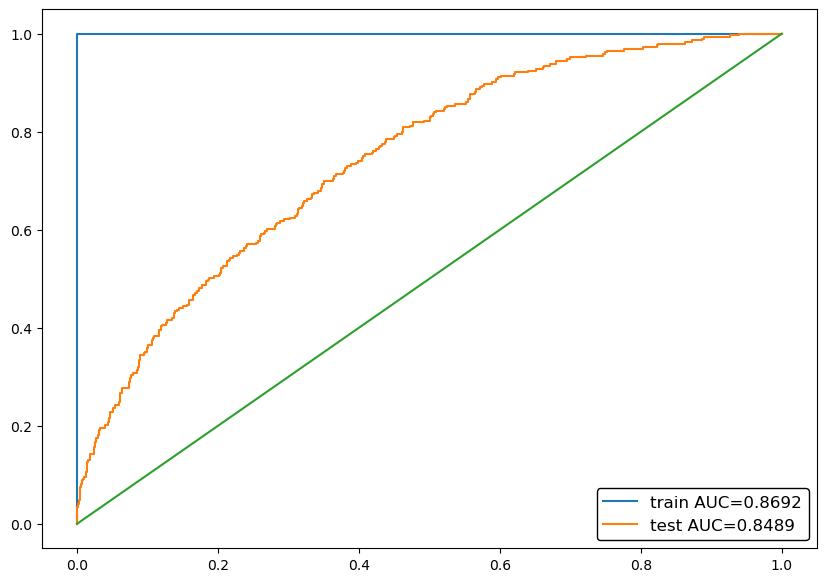

In [66]:
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Я потестила модели с фичёй TotalSpent и без неё, с ней получилось лучше. Поэтому, несмотря на мысли выше (в разделе с анализом данных), из данных она не удалена. 

# Предсказания

In [67]:
best_model = model

In [68]:
X_valid = pd.read_csv('./test.csv')

# убираем пробелы
X_valid['TotalSpent'][X_valid['TotalSpent']==' '] = X_valid['MonthlySpending']
X_valid['TotalSpent'] = X_valid['TotalSpent'].astype(float)
X_valid['IsSeniorCitizen'] = X_valid['IsSeniorCitizen'].astype(object)

/var/folders/_5/8sz306zn1332jvkj4z4k5yl80000gn/T/ipykernel_83485/3724121480.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['TotalSpent'][X_valid['TotalSpent']==' '] = X_valid['MonthlySpending']


In [71]:
cat_cols = X_valid.select_dtypes(include=['object', 'category']).columns.tolist()
for cat in cat_cols:
    X_valid[cat] = X_valid[cat].astype('category')

In [72]:
valid_pool = Pool(X_valid, cat_features=cat_cols)
# Make predictions
y_valid_pred = model.predict_proba(valid_pool)[:, 1]

In [73]:
submission = pd.read_csv('./submission.csv', index_col=0)

submission['Churn'] = y_valid_pred 
submission.to_csv('./my_submission.csv')

Score на Kaggle с CatBoost'ом получился 0.85, ура)